# Projektvorstellung: WhatCable
von Katharina Schütz, Onur Erden, Leon Lovric, Romeo Gerstlauer

## Installationen & Import

In [2]:
#!pip install -q git+https://github.com/tensorflow/examples.git#egg=tensorflow-examples[model_maker]
#!pip install git+https://github.com/aleju/imgaug.git --upgrade
#!pip install keras --upgrade

In [3]:
import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader
from tensorflow_examples.lite.model_maker.core.task import image_classifier
from tensorflow_examples.lite.model_maker.core.task.model_spec import ImageModelSpec
from tensorflow_examples.lite.model_maker.core.task.configs import QuantizationConfig

import matplotlib.pyplot as plt
import pathlib

import time

/home/ai/venv/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:38: UserWarning: You are currently using a nightly version of TensorFlow (2.3.0-dev20200602). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


## Data Augmentation

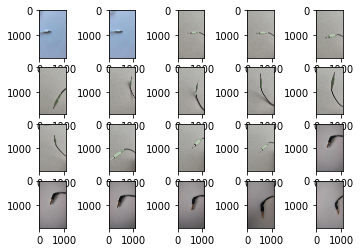

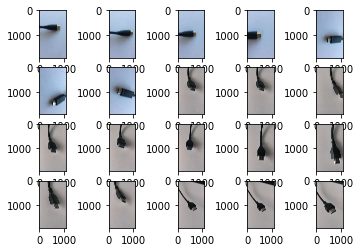

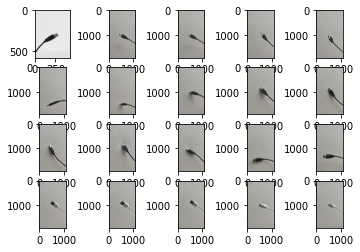

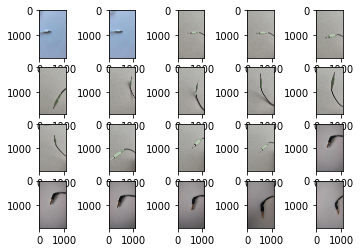

In [4]:
import imageio
import imgaug as ia
%matplotlib inline

from skimage.io import imread_collection, imsave, imshow_collection

seq_images_hdmi = imread_collection("/home/ai/venv/bin/bilddaten/weiss_test1/hdmi/*.jpg", conserve_memory=True)
seq_images_usb_a = imread_collection("/home/ai/venv/bin/bilddaten/weiss_test1/usb_a/*.jpg", conserve_memory=True)
seq_images_klinkenkabel = imread_collection("/home/ai/venv/bin/bilddaten/weiss_test1/klinkenkabel/*.jpg", conserve_memory=True)

imshow_collection(seq_images_hdmi[0:20])
imshow_collection(seq_images_usb_a[0:20])
imshow_collection(seq_images_klinkenkabel[0:20])

HDMI-Test-Augmentation (10 Bilder) done in 1.47s
HDMI-Augmentation done in 70.32s


<ipython-input-5-7af28f1636bd>:53: UserWarning: /home/ai/venv/bin/bilddaten/aug_images_02/usb_a/usb_a_385_0 is a low contrast image
  imsave(aug_name, aug(image=seq_images_usb_a[x]), format=".jpg")


USB_A-Augmentation done in 69.75s
Klinkenkabel-Augmentation done in 73.17s
HDMI-Test-Augmentation (10 Bilder) done in 1.37s
HDMI-Augmentation done in 67.03s
USB_A-Augmentation done in 66.14s
Klinkenkabel-Augmentation done in 64.75s
HDMI-Test-Augmentation (10 Bilder) done in 2.05s
HDMI-Augmentation done in 66.86s
USB_A-Augmentation done in 68.84s
Klinkenkabel-Augmentation done in 68.96s
HDMI-Test-Augmentation (10 Bilder) done in 1.38s
HDMI-Augmentation done in 66.90s
USB_A-Augmentation done in 67.40s
Klinkenkabel-Augmentation done in 67.80s
HDMI-Test-Augmentation (10 Bilder) done in 1.28s
HDMI-Augmentation done in 66.86s
USB_A-Augmentation done in 70.70s
Klinkenkabel-Augmentation done in 67.01s
HDMI-Test-Augmentation (10 Bilder) done in 1.32s
HDMI-Augmentation done in 64.17s
USB_A-Augmentation done in 63.15s
Klinkenkabel-Augmentation done in 66.74s
HDMI-Test-Augmentation (10 Bilder) done in 1.41s
HDMI-Augmentation done in 66.64s
USB_A-Augmentation done in 67.73s
Klinkenkabel-Augmentatio

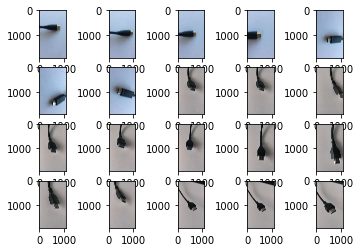

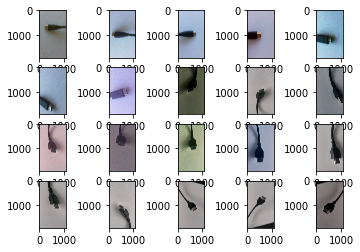

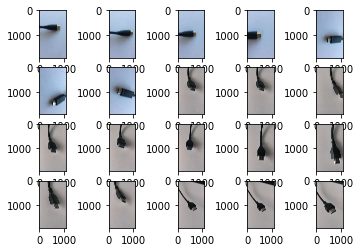

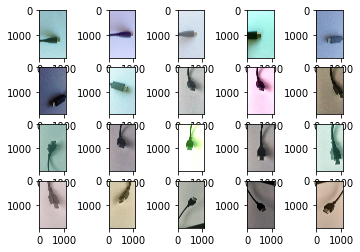

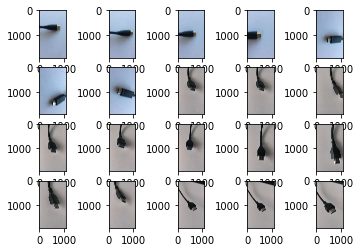

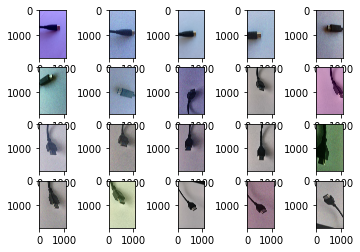

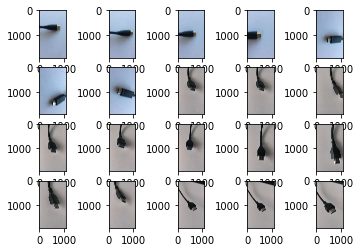

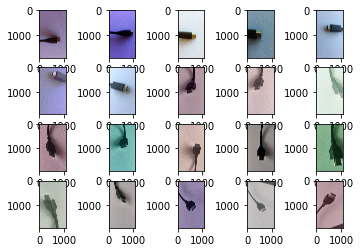

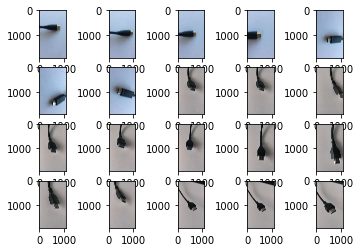

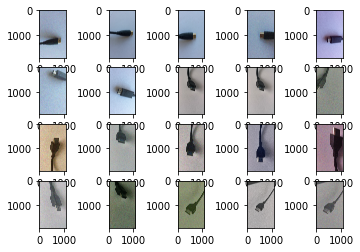

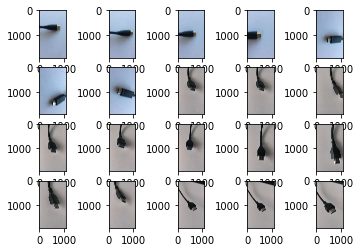

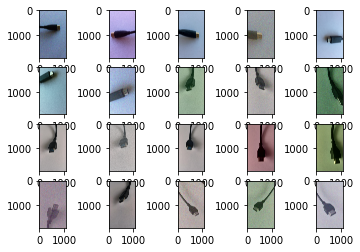

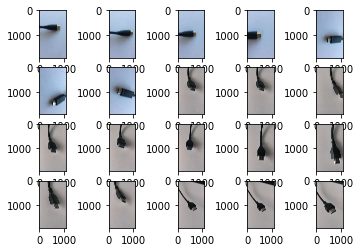

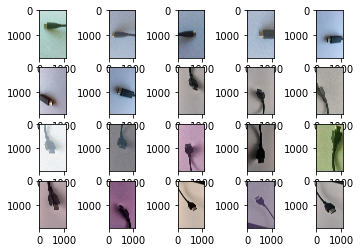

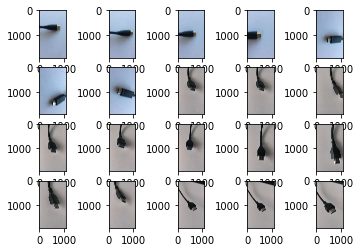

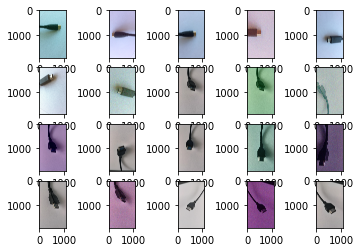

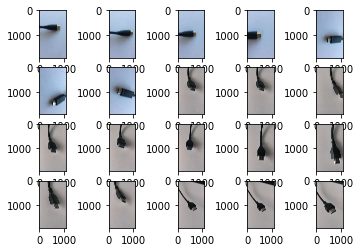

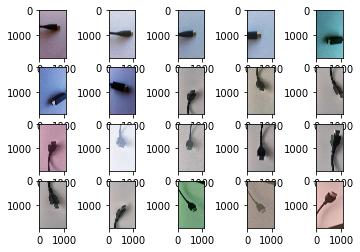

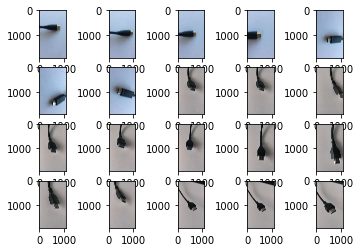

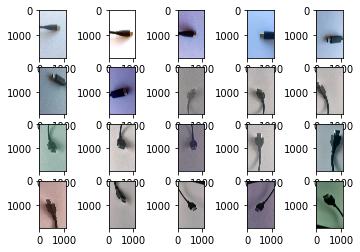

In [5]:
from imgaug import augmenters as iaa

for seed_x in range(10):
    
    ia.seed(seed_x)    
    
    aug = iaa.SomeOf((0, None), [
        iaa.Sharpen(alpha=0.4), # Bildschärfe erhöhen
        iaa.Affine(rotate=180), # rotieren
        iaa.AdditiveGaussianNoise(scale=0.1*255, per_channel=False), # Rauschen
        iaa.AdditiveGaussianNoise(scale=0.2*255, per_channel=True), # Rauschen einzeln pro Channel
        iaa.Add((-25,25), per_channel = True), # Pixelwerte zusammen
        iaa.Add((-25,25), per_channel = False), # Pixelwerte einzeln
        iaa.Add((-30, 30), per_channel=0.5), # Pixelwerte zusammen, Hälfte einzeln
        iaa.MotionBlur(k=3, angle=[-45, 45]), # leichter MotionBlur
        iaa.Fliplr(1.0), # Spiegeln links-rechts
        iaa.Flipud(1.0), # Spiegeln oben-unten
        #iaa.Grayscale(alpha=(0.0, 1.0)),
        iaa.GammaContrast((0.5, 2.0)),
        iaa.Sharpen(alpha=(0.0, 1.0), lightness=(0.75, 2.0)),
        iaa.PerspectiveTransform(scale=(0.01, 0.12)) # schräg
    ])
    

    #images_aug_hdmi = seq(images=seq_images_hdmi[0:20])
    images_aug_hdmi = aug(images=seq_images_hdmi[0:20])
    imshow_collection(seq_images_hdmi[0:20])
    imshow_collection(images_aug_hdmi[0:20])

          
    time_start = time.time()
    
    for x in range(10):
        aug_name = "/home/ai/venv/bin/bilddaten/zeittest_02/"+"hdmi_" + str(x) + "_" + str(seed_x)
        imsave(aug_name, aug(image=seq_images_hdmi[x]), format=".jpg")
        
    time_end = time.time()
    print("HDMI-Test-Augmentation (10 Bilder) done in %.2fs" % (time_end - time_start))
                 
    time_start = time.time()
    
    for x in range(len(seq_images_hdmi)):
        aug_name = "/home/ai/venv/bin/bilddaten/aug_images_02/hdmi/"+"hdmi_" + str(x) + "_" + str(seed_x)
        imsave(aug_name, aug(image=seq_images_hdmi[x]), format=".jpg")
        
    time_end = time.time()
    print("HDMI-Augmentation done in %.2fs" % (time_end - time_start))
    
    
    time_start = time.time()
    for x in range(len(seq_images_usb_a)):
        aug_name = "/home/ai/venv/bin/bilddaten/aug_images_02/usb_a/"+"usb_a_" + str(x) + "_" + str(seed_x)
        imsave(aug_name, aug(image=seq_images_usb_a[x]), format=".jpg")
    time_end = time.time()    
    print("USB_A-Augmentation done in %.2fs" % (time_end - time_start))    
        
    time_start = time.time()    
    for x in range(len(seq_images_klinkenkabel)):
        aug_name = "/home/ai/venv/bin/bilddaten/aug_images_02/klinkenkabel/"+"klinkenkabel_" + str(x) + "_" + str(seed_x)
        imsave(aug_name, aug(image=seq_images_klinkenkabel[x]), format=".jpg")
    time_end = time.time()
    print("Klinkenkabel-Augmentation done in %.2fs" % (time_end - time_start))

## Training: TensorFlow Lite Model Maker

### Datenimport

Input Daten werden geladen und in Trainings-/Test- und Validierungsdaten aufgeteilt. (80/10/10)

In [8]:
data = ImageClassifierDataLoader.from_folder('/home/ai/venv/bin/bilddaten/aug_images_02')
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

INFO:tensorflow:Load image with size: 13800, num_label: 3, labels: hdmi, klinkenkabel, usb_a.


Hier werden 15 augmentierte Fotos mit entsprechendem Label ausgegeben.

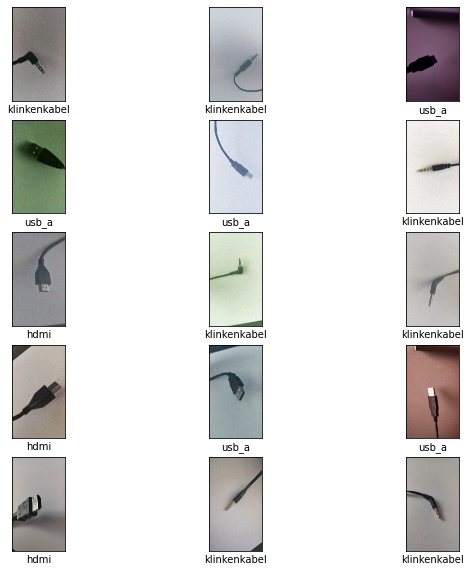

In [7]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.dataset.take(15)):
  plt.subplot(5,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

Import des gewuenschten Modells (hier MobileNet_v2_100_244) und Konfiguration der Create-Methode

In [7]:
mobilenet_v2_spec = ImageModelSpec(
    uri='https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4')
mobilenet_v2_spec.input_image_shape = [224, 224]

model = image_classifier.create(train_data, validation_data=validation_data, model_spec=mobilenet_v2_spec, 
                                epochs=5, batch_size=32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
None
INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Epoch 1/5
690/690 [==============================] - 218s 316ms/step - loss: 0.8591 - accuracy: 0.7385 - val_loss: 0.7779 - val_accuracy: 0.7551
Epoch 2/5
690/690 [==============================] - 212s 308ms/step - loss: 0.8164 - accuracy: 0.7739 - val_loss: 0.6454 - val_accuracy: 0.8314
Epoch 3/5
690/690 [==============================] - 213s 308ms/step - loss: 0.7950 - accuracy: 0.7880 - val_loss: 0.6003 - val_accuracy: 0.8576
Epoch 4/5
690/690 [==============================] - 208s 301ms/step - loss: 0.7618 - accuracy: 0.7959 - val_loss: 0.6142 - val_accuracy: 0.8503
Epoch 5/5
690/690 [==============================] - 208s 301ms/step - loss: 0.7571 - accuracy: 0.7998 - val_loss: 0.6532 - val_accuracy: 0.8278


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


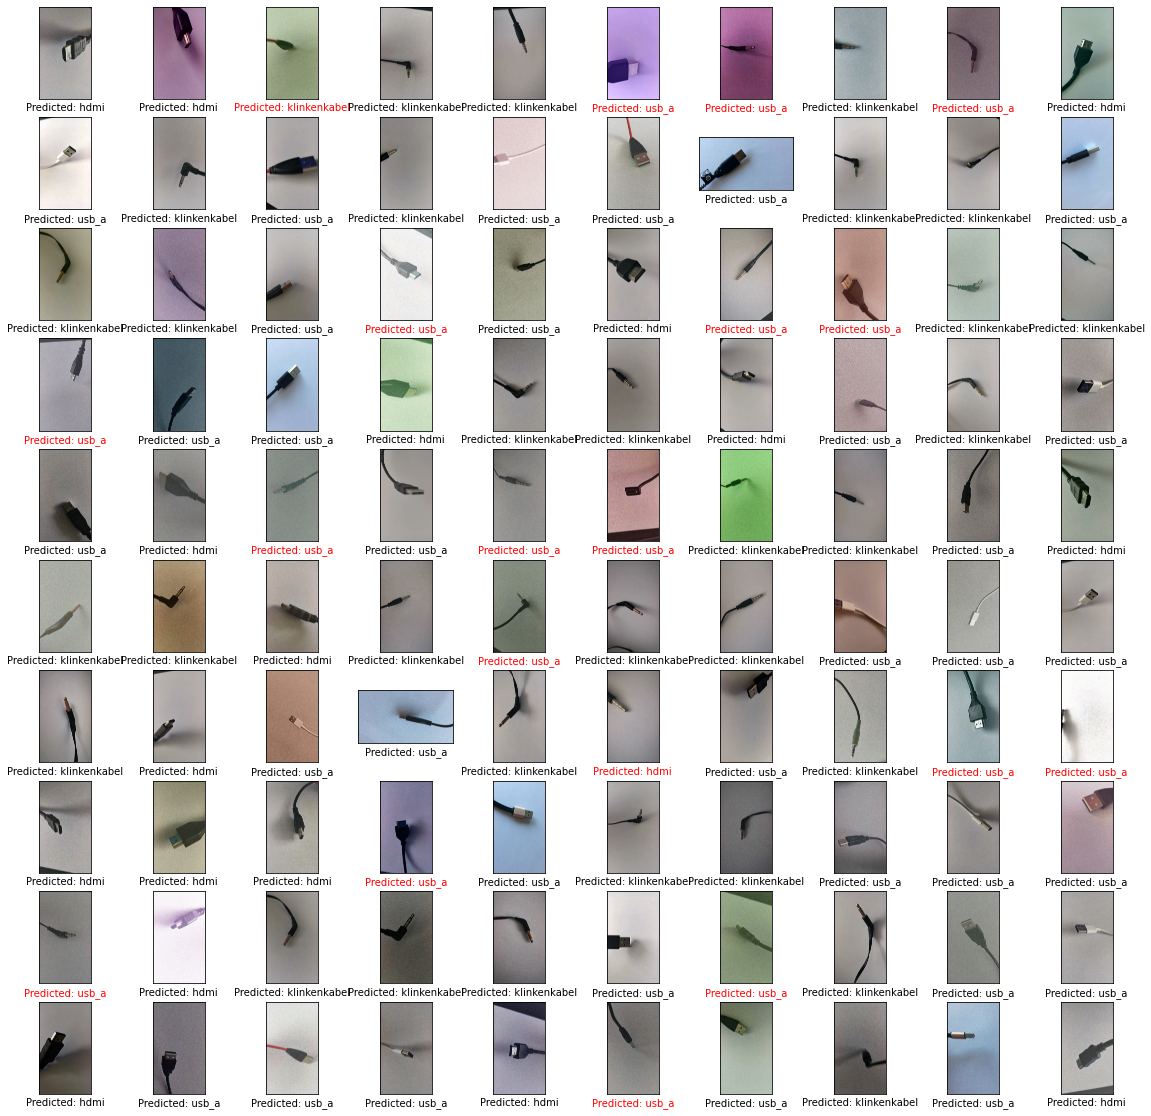

In [10]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.dataset.take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

Nachfolgend wird das Modell noch exportiert und abgespeichert.

In [11]:
# Export model
model.export(export_dir='/home/ai/venv/bin/bilddaten/modelle_exportiert')

INFO:tensorflow:Saving labels in /home/ai/venv/bin/bilddaten/modelle_exportiert/labels.txt.


INFO:tensorflow:Saving labels in /home/ai/venv/bin/bilddaten/modelle_exportiert/labels.txt.


Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/tmpji56k12x/assets


INFO:tensorflow:Assets written to: /tmp/tmpji56k12x/assets


Eine Möglichkeit, das TensorFlow Lite Modell zu evaluieren:

In [12]:
# Read TensorFlow Lite model from TensorFlow Lite file.
with tf.io.gfile.GFile('model.tflite', 'rb') as f:
  model_content = f.read()

# Read label names from label file.
with tf.io.gfile.GFile('labels.txt', 'r') as f:
  label_names = f.read().split('\n')

# Initialze TensorFlow Lite inpterpreter.
interpreter = tf.lite.Interpreter(model_content=model_content)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]['index']
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

# Run predictions on each test image data and calculate accuracy.
accurate_count = 0
for i, (image, label) in enumerate(test_data.dataset):
    # Pre-processing should remain the same. Currently, just normalize each pixel value and resize image according to the model's specification.
    image, _ = model.preprocess(image, label)
    # Add batch dimension and convert to float32 to match with the model's input
    # data format.
    image = tf.expand_dims(image, 0).numpy()

    # Run inference.
    interpreter.set_tensor(input_index, image)
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the label with highest
    # probability.
    predict_label = np.argmax(output()[0])
    # Get label name with label index.
    predict_label_name = label_names[predict_label]

    accurate_count += (predict_label == label.numpy())

accuracy = accurate_count * 1.0 / test_data.size
print('TensorFlow Lite model accuracy = %.4f' % accuracy)

# Oder:
# Evaluate the customized model
loss, accuracy = model.evaluate(test_data)

TensorFlow Lite model accuracy = 0.7377
